# Portfolio Rebalancer in Python

Timely and consistent rebalancing is a cornerstone of modern portfolio theory. Rebalancing can magnify returns by selling high and buying low, and reduce long-term risk by ensuring the portfolio adheres to its designated risk tolerance. This project was inspired by a lack of free tools for simply rebalancing an existing portfolio. Sure, we can all use a worksheet to do the math each time, but why not automate it? With inspiration from the work of kdboller we use Pandas, the Tiingo API, and some simple math to calculate how to optimally rebalance a portfolio given a target allocation. This is a simple no-frills portfolio rebalance exercise and does not factor in important considerations such as tax efficiency, transaction costs, or alternate approaches such as stock-out rebalances, or bond-floor settings. Future versions of this project may contemplate these extra factors.  


Steps:  
1. Set triggers to rebalance (time or threshold or both)
2. Define our current Portfolio (accounttype, time, ticker, shares, cost basis, price)  
3. Define our target allocation (ticker, allocation)  
4. Factor in any new money being invested  
5. Calculate initial transactions needed to hit target allocation  
6. Determine which transactions are valid based on rebalance triggers
7. Iteratively determine sells and buys required to get as close as possible to target allocation  


References:

[pythonsp500 by kdboller](https://nbviewer.jupyter.org/github/kdboller/pythonsp500/blob/a7066d998ff046c3cc8b26ece3b0efdf00959d57/Investment%20Portfolio%20Python%20Notebook_03_2018_blog%20example.ipynb)

[Portfolio Rebalancing by bogleheads wiki](https://www.bogleheads.org/wiki/Rebalancing)

In [1]:
#Phases:
#1. (done) Rebalance an existing portfolio
#2. (done) Rebalance new money in
#3. Factor in account types and tax consideratons (Tax Location)
#4. Automatically track portfolio changes/drift using API (will depend on broker capability)
#5. Email alerts

#Feature Ideas:
#Calculate capital gains and losses (and their tax status LT vs. ST)
#Define target allocation at asset-class / domestic-international (or other) levels - then filter it down to securities level
#Enable buying/selling fractional shares for asset types that allow it (ETFs, individual stocks, etc..)
#Factor in trading fees
#Look at what Betterment does for ideas: https://help.betterment.com/hc/en-us/articles/115004257146-How-and-when-is-my-portfolio-rebalanced-?_ga=2.5109811.1454930060.1543610672-1361255251.1543610672
#Convert the top-level allocation to the ticker-level allocation (see: https://docs.google.com/spreadsheets/d/1Ig0sYTdfSqcM2OHJDa7m_vRvQeAQO823s2Nw2rGmL5g/edit#gid=628577776)
#Calculate Tax Location for assets (define optimal tax location depending on the security)
#Calculate Tax Loss Harvesting (maybe a separate app)
#Decide on optimal rebalance strategy (sell assets, invest additional assets, factor in taxable accounts vs. tax deferred)

## Code

In [139]:
#Lets import the necessary packages
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import datetime
import decimal
from pandas_datareader import data as pdr
from keys import tiingo_key
#define todays datetime
now = datetime.datetime.now()

In [148]:
#Settings
new_money_in = 0
#Set our rebalance threshold
rebal_threshold = .05 #allowable allocation drift
rebal_timeframe = 180 #in days

In [149]:
#Define target and current allocations
#create our target allocation
columns_t = ['ticker','allocation_target','assetclass']
positions_t = [['VTSAX',0.5652,'ST'],
             ['VIGAX',0.0131,'ST'],
             ['VSMAX',0.0066,'ST'],
             ['VSEQX',0.0066,'ST'],
             ['VWIGX',0.0507,'ST'],
             ['VTRIX',0.0507,'ST'],
             ['VTIAX',0.1521,'ST'],
             ['VBTLX',0.035,'BD'],
             ['VTABX',0.015,'BD'],
             ['VGSLX',0.05,'RE'],
             ['VNQI',0.01,'RE'],
             ['VDE',0.03,'ST'],
             ['GLD',0.015,'CS']]

#set our current portfolio
columns_c = ['accounttype','accountid','lastrebaldate','ticker','assetclass','basisdate','costbasis','shares']
positions_c = [['RIRA','3484','2018-11-16','VBTLX','BD','2018-11-16',1,913.483],
             ['RIRA','3484','2018-11-16','VTIAX','ST','2018-11-16',1,514.298],
             ['RIRA','3484','2018-11-16','VTSAX','ST','2018-11-16',10,151.121],
             ['RIRA','6732','2018-11-16','VBTLX','BD','2018-11-16',1,772.407],
             ['RIRA','6732','2018-11-16','VBMFX','BD','2018-11-16',1,0],
             ['RIRA','6732','2018-11-16','VTSAX','ST','2018-11-16',20,151.578],
             ['TAXB','8096','2018-11-16','ATVI','ST','2018-11-16',1,7],
             ['TAXB','8096','2018-11-16','AMSC','ST','2018-11-16',1,41],
             ['TAXB','8096','2018-11-16','AAPL','ST','2018-11-16',1,3.14],
             ['TAXB','8096','2018-11-16','EA','ST','2018-11-16',1,4],
             ['TAXB','8096','2018-11-16','ROBO','ST','2018-11-16',1,24.006],
             ['TAXB','8096','2018-11-16','NVDA','ST','2018-11-16',1,3.01],
             ['TAXB','8096','2018-11-16','TCEHY','ST','2018-11-16',1,25],
             ['TAXB','8096','2018-11-16','TSLA','ST','2018-11-16',1,11],
             ['TAXB','8096','2018-11-16','ESGV','ST','2018-11-16',1,19],
             ['TAXB','8096','2018-11-16','VSGX','ST','2018-11-16',1,20],
             ['TAXB','8096','2018-11-16','VTSAX','ST','2018-11-16',10,549.871],
             ['TAXB','8096','2018-11-16','VMFXX','CS','2018-11-16',1,25516.08]]

In [150]:
#lookup table for account type abbreviations
accounttypes = {'TAXB':'Taxable Brokerage', '401K':'401k', 'RIRA':'Roth-IRA', 'TIRA':'Traditional-IRA'}
assetclasses = {'ST':'Equity Stocks', 'BD':'Bonds Fixed-Income', 'CS':'Cash and Commodities', 'RE':'Real-Estate', 'ALT':'Alternatives'}
assettypes = {'SEC':'Individual Security', 'ETF':'Exchange Traded Fund', 'MF': 'Mutual Fund', 'IF':'Index Fund'}
assetregion = {'D':'Domestic','I':'International'}

#initialize target portfolio
targetalloc = pd.DataFrame(columns = columns_t, data = positions_t)
total=decimal.Decimal(targetalloc.allocation_target.sum())
if round(total,4) != 1:
    print('Target Allocation not 100% : {}'.format(int(total)))

#initialize current portfolio
start_port = pd.DataFrame(columns = columns_c, data = positions_c)
start_port.lastrebaldate = pd.to_datetime(start_port.lastrebaldate)
start_port.basisdate = pd.to_datetime(start_port.basisdate)

#custom apply function
def f(x):
    d = {}
    d['lastrebaldate'] = x['lastrebaldate'].max()
    d['assetclass'] = x['assetclass'].max()
    d['basisdate'] = x['basisdate'].min()
    d['costbasis'] = (x['costbasis'] * x['shares']).sum()/(x['shares'].sum() or 1) #weighted avg
    d['shares'] = x['shares'].sum()
    return pd.Series(d, index=['lastrebaldate', 'assetclass', 'basisdate', 'costbasis', 'shares'])

#aggregate by ticker to account for duplicate securities held in different accounts
agg_port = start_port.groupby(['ticker']).apply(f)

#Define list of distinct tickers we care about
tickers = set(targetalloc.ticker.unique().tolist()+start_port.ticker.unique().tolist())

In [15]:
#Next we pull the latest prices from Tiingo (YahooFinance is buggy, and IEX does not contain mutual fund data)
#Tiingo limits for free API: 500 unique tickers ever, 500 requests/hr, 20,000 requests/day
#https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#tiingo
#Tiingo API key required: set 'tiingo_key' value in python file called 'keys.py' in same directory as this script
now = datetime.datetime.now()
yesterday = now - datetime.timedelta(3) #avoids weekends with no data - need better weekend detection
start = datetime.datetime(yesterday.year, yesterday.month, yesterday.day)
end = datetime.datetime(now.year, now.month, now.day)

bad_tickers = []
for i, t in enumerate(tickers):
    try:
        if i==0:
            ohlc = pdr.get_data_tiingo(t, api_key=tiingo_key).tail(1).close
        else:
            ohlc = ohlc.append(pdr.get_data_tiingo(t, api_key=tiingo_key).tail(1).close)
    except:
        bad_tickers.append(t)
        
#print(bad_tickers)
ohlc = ohlc.to_frame(name='close')

#drop our date index since its only the latest data
ohlc2=ohlc.reset_index(level=1, drop=True)

In [151]:
#concatenate target allocation and latest prices with our portfolio
start_port_c = pd.merge(agg_port, targetalloc, on ='ticker', how ='outer')
final_port = pd.merge(start_port_c, ohlc2, left_on ='ticker', right_index = True, how = 'left')

#set target to zero for tickers held but not present in our target allocation, set initial basisdate and costbasis for new securities entering the portfolio
final_port.fillna(value = {'allocation_target':0.0,'shares':0.0,'basisdate':pd.to_datetime(now.strftime("%Y-%m-%d")),'costbasis':final_port.close,'assetclass_x':final_port.assetclass_y},inplace = True)
final_port.drop(['assetclass_y'],axis=1,inplace=True)
final_port.rename(columns={'assetclass_x':'assetclass'},inplace=True)

#manual override for VMFXX which Tiingo can't find. Its a Vanguard money market account so price = $1
final_port.loc[final_port.ticker=='VMFXX',['close']] = 1.0

#calculate holding values and current allocation
final_port['value'] = final_port.close * final_port.shares #calculate value as price x shares
final_port.loc[final_port.value.isna() & final_port.shares.isna(),['value']]=0.0 #for securities not currently held but in our target (and close price failed to return), establish zero value
final_port['allocation'] = final_port.value / final_port.value.sum()
final_port['correction'] = final_port.allocation_target - final_port.allocation

In [152]:
#factor in any new money entering the portfolio and determine necessary changes in value and shares
#this method rebalances and factors in new money simultaneously - there may be more efficient methods
total_val = final_port.value.sum()
final_port['new_money_in'] = new_money_in * final_port.allocation_target #Account for new money in
final_port['value_chg'] = (total_val * final_port.correction) + final_port.new_money_in
final_port['shares_chg'] = final_port.value_chg / final_port.close
final_port.loc[final_port.value_chg.isna() & final_port.shares > 0,['shares_chg']]=-final_port.shares #sell all shares of securities not in our target portfolio

#round off shares to whole numbers, except when we are fully exiting a position
final_port['shares_chg_round'] = final_port.shares_chg
final_port = final_port.astype({'shares_chg_round': int})
final_port['final_shares_chg'] = final_port.shares_chg
final_port.loc[final_port.shares_chg+final_port.shares!=0,['final_shares_chg']]=final_port.shares_chg_round*1.0
final_port.drop(['shares_chg_round'],axis=1,inplace=True)

#create timedelta int column
final_port['timedelta'] = (final_port.lastrebaldate - pd.to_datetime(now.strftime("%Y-%m-%d"))).dt.days
final_port.timedelta.fillna(0,inplace=True)

#define rebalance flags to determine if we must rebalance
final_port['rebal_flag_thresh'] = np.where((abs(final_port.correction)<=rebal_threshold) & (final_port.allocation > 0),0,1)
final_port['rebal_flag_time'] = np.where(final_port.timedelta >= rebal_timeframe,1,0)
final_port['rebal_flag'] = np.where(final_port.rebal_flag_thresh + final_port.rebal_flag_time >= 1,1,0)

#These rows do not meet our rebalance threshold or timeframe cutoff - so we should set their change values to 0
#The exception is if new_money_in must be considered, in which case we will still rebalance by investing the new money
final_port.loc[(final_port.rebal_flag==0) & (final_port.new_money_in==0), ['value_chg','shares_chg','final_shares_chg']] = 0

#Calculate initial new shares and values
final_port['new_shares'] = (final_port.shares + final_port.final_shares_chg)
final_port['new_value'] = final_port.new_shares * final_port.close #due to share rounding, there will be slight variance vs. portfolio starting value
final_port['new_value_chg'] = final_port.final_shares_chg * final_port.close

In [153]:
final_port

,ticker,lastrebaldate,assetclass,basisdate,costbasis,shares,allocation_target,close,value,allocation,correction,new_money_in,value_chg,shares_chg,final_shares_chg,timedelta,rebal_flag_thresh,rebal_flag_time,rebal_flag,new_shares,new_value,new_value_chg
0,AAPL,2018-11-16,ST,2018-11-16,1.000000,3.140,0.0000,156.83,492.44620,0.004197,-0.004197,0.0,0.000000,0.000000,0.00,-35.0,0,0,0,3.140,492.44620,0.00
1,AMSC,2018-11-16,ST,2018-11-16,1.000000,41.000,0.0000,9.72,398.52000,0.003397,-0.003397,0.0,0.000000,0.000000,0.00,-35.0,0,0,0,41.000,398.52000,0.00
2,ATVI,2018-11-16,ST,2018-11-16,1.000000,7.000,0.0000,47.05,329.35000,0.002807,-0.002807,0.0,0.000000,0.000000,0.00,-35.0,0,0,0,7.000,329.35000,0.00
3,EA,2018-11-16,ST,2018-11-16,1.000000,4.000,0.0000,77.44,309.76000,0.002640,-0.002640,0.0,0.000000,0.000000,0.00,-35.0,0,0,0,4.000,309.76000,0.00
4,ESGV,2018-11-16,ST,2018-11-16,1.000000,19.000,0.0000,42.32,804.08000,0.006853,-0.006853,0.0,0.000000,0.000000,0.00,-35.0,0,0,0,19.000,804.08000,0.00
5,NVDA,2018-11-16,ST,2018-11-16,1.000000,3.010,0.0000,135.10,406.65100,0.003466,-0.003466,0.0,0.000000,0.000000,0.00,-35.0,0,0,0,3.010,406.65100,0.00
6,ROBO,2018-11-16,ST,2018-11-16,1.000000,24.006,0.0000,32.34,776.35404,0.006617,-0.006617,0.0,0.000000,0.000000,0.00,-35.0,0,0,0,24.006,776.35404,0.00
7,TCEHY,2018-11-16,ST,2018-11-16,1.000000,25.000,0.0000,38.24,956.00000,0.008148,-0.008148,0.0,0.000000,0.000000,0.00,-35.0,0,0,0,25.000,956.00000,0.00
8,TSLA,2018-11-16,ST,2018-11-16,1.000000,11.000,0.0000,315.38,3469.18000,0.029568,-0.029568,0.0,0.000000,0.000000,0.00,-35.0,0,0,0,11.000,3469.18000,0.00
9,VBMFX,2018-11-16,BD,2018-11-16,0.000000,0.000,0.0000,10.41,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,-35.0,1,0,1,0.000,0.00000,0.00


In [154]:
#create a balance counter initially set to the value of new money in (since this is available to invest)
bal = new_money_in

#next we use a value-sorted portfolio to iteratively sell/buy to get our final execution strategy
for index, row in final_port.sort_values(by='new_value_chg',ascending=True).iterrows():
    bal-=row.new_value_chg
    if bal > 0:
        final_port.loc[index,'execution_value'] = row.new_value
        final_port.loc[index,'execution_shares_chg'] = row.final_shares_chg
    else:
        final_port.loc[index,'execution_value'] = row.new_value + bal
        final_port.loc[index,'execution_shares_chg'] = int((row.new_value + bal)/row.close)
    print('Evaluating {} {}, new bal is {}'.format(row.ticker,row.new_value_chg,bal))

#calculate final values for execution
final_port['execution_value_chg'] = final_port.execution_shares_chg * final_port.close
final_port['execution_shares'] = final_port.execution_shares_chg + final_port.shares
final_port['execution_allocation'] = final_port.execution_value / final_port.execution_value.sum()

#double check our work - the final portfolio should be well within the rebalance threshold we defined
if len(final_port[(final_port.execution_allocation - final_port.allocation_target) > rebal_threshold]) > 0:
    print('ERROR: Target Portfolio not achieved')
else:
    print('Allocation Success!')

Evaluating VMFXX -25516.08, new bal is 25516.08
Evaluating VBTLX -13439.31, new bal is 38955.39
Evaluating AAPL 0.0, new bal is 38955.39
Evaluating VTIAX 0.0, new bal is 38955.39
Evaluating VBMFX 0.0, new bal is 38955.39
Evaluating TSLA 0.0, new bal is 38955.39
Evaluating TCEHY 0.0, new bal is 38955.39
Evaluating VSGX 0.0, new bal is 38955.39
Evaluating NVDA 0.0, new bal is 38955.39
Evaluating ESGV 0.0, new bal is 38955.39
Evaluating EA 0.0, new bal is 38955.39
Evaluating ATVI 0.0, new bal is 38955.39
Evaluating ROBO 0.0, new bal is 38955.39
Evaluating AMSC 0.0, new bal is 38955.39
Evaluating VSMAX 750.0, new bal is 38205.39
Evaluating VSEQX 770.53, new bal is 37434.86
Evaluating VNQI 1136.73, new bal is 36298.13
Evaluating VIGAX 1495.5600000000002, new bal is 34802.57
Evaluating GLD 1669.36, new bal is 33133.21
Evaluating VTABX 1745.11, new bal is 31388.1
Evaluating VDE 3509.7999999999997, new bal is 27878.3
Evaluating VGSLX 5778.54, new bal is 22099.76
Evaluating VWIGX 5933.42, new b

In [155]:
#Lets look at all our work to get to our target portfolio
final_port

,ticker,lastrebaldate,assetclass,basisdate,costbasis,shares,allocation_target,close,value,allocation,correction,new_money_in,value_chg,shares_chg,final_shares_chg,timedelta,rebal_flag_thresh,rebal_flag_time,rebal_flag,new_shares,new_value,new_value_chg,execution_value,execution_shares_chg,execution_value_chg,execution_shares,execution_allocation
0,AAPL,2018-11-16,ST,2018-11-16,1.000000,3.140,0.0000,156.83,492.44620,0.004197,-0.004197,0.0,0.000000,0.000000,0.00,-35.0,0,0,0,3.140,492.44620,0.00,492.44620,0.00,0.00,3.140,0.004197
1,AMSC,2018-11-16,ST,2018-11-16,1.000000,41.000,0.0000,9.72,398.52000,0.003397,-0.003397,0.0,0.000000,0.000000,0.00,-35.0,0,0,0,41.000,398.52000,0.00,398.52000,0.00,0.00,41.000,0.003397
2,ATVI,2018-11-16,ST,2018-11-16,1.000000,7.000,0.0000,47.05,329.35000,0.002807,-0.002807,0.0,0.000000,0.000000,0.00,-35.0,0,0,0,7.000,329.35000,0.00,329.35000,0.00,0.00,7.000,0.002807
3,EA,2018-11-16,ST,2018-11-16,1.000000,4.000,0.0000,77.44,309.76000,0.002640,-0.002640,0.0,0.000000,0.000000,0.00,-35.0,0,0,0,4.000,309.76000,0.00,309.76000,0.00,0.00,4.000,0.002640
4,ESGV,2018-11-16,ST,2018-11-16,1.000000,19.000,0.0000,42.32,804.08000,0.006853,-0.006853,0.0,0.000000,0.000000,0.00,-35.0,0,0,0,19.000,804.08000,0.00,804.08000,0.00,0.00,19.000,0.006853
5,NVDA,2018-11-16,ST,2018-11-16,1.000000,3.010,0.0000,135.10,406.65100,0.003466,-0.003466,0.0,0.000000,0.000000,0.00,-35.0,0,0,0,3.010,406.65100,0.00,406.65100,0.00,0.00,3.010,0.003466
6,ROBO,2018-11-16,ST,2018-11-16,1.000000,24.006,0.0000,32.34,776.35404,0.006617,-0.006617,0.0,0.000000,0.000000,0.00,-35.0,0,0,0,24.006,776.35404,0.00,776.35404,0.00,0.00,24.006,0.006617
7,TCEHY,2018-11-16,ST,2018-11-16,1.000000,25.000,0.0000,38.24,956.00000,0.008148,-0.008148,0.0,0.000000,0.000000,0.00,-35.0,0,0,0,25.000,956.00000,0.00,956.00000,0.00,0.00,25.000,0.008148
8,TSLA,2018-11-16,ST,2018-11-16,1.000000,11.000,0.0000,315.38,3469.18000,0.029568,-0.029568,0.0,0.000000,0.000000,0.00,-35.0,0,0,0,11.000,3469.18000,0.00,3469.18000,0.00,0.00,11.000,0.029568
9,VBMFX,2018-11-16,BD,2018-11-16,0.000000,0.000,0.0000,10.41,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,-35.0,1,0,1,0.000,0.00000,0.00,0.00000,0.00,0.00,0.000,0.000000


In [156]:
#Assemble our final output
display_port = final_port[['lastrebaldate','ticker','costbasis','shares','close','allocation','allocation_target','execution_value_chg','execution_shares_chg','execution_shares','execution_value','execution_allocation']]

#To complete rebalancing investor should transact the shares in the 'execution_shares_chg' column in any order
display_port

,lastrebaldate,ticker,costbasis,shares,close,allocation,allocation_target,execution_value_chg,execution_shares_chg,execution_shares,execution_value,execution_allocation
0,2018-11-16,AAPL,1.000000,3.140,156.83,0.004197,0.0000,0.00,0.00,3.140,492.44620,0.004197
1,2018-11-16,AMSC,1.000000,41.000,9.72,0.003397,0.0000,0.00,0.00,41.000,398.52000,0.003397
2,2018-11-16,ATVI,1.000000,7.000,47.05,0.002807,0.0000,0.00,0.00,7.000,329.35000,0.002807
3,2018-11-16,EA,1.000000,4.000,77.44,0.002640,0.0000,0.00,0.00,4.000,309.76000,0.002640
4,2018-11-16,ESGV,1.000000,19.000,42.32,0.006853,0.0000,0.00,0.00,19.000,804.08000,0.006853
5,2018-11-16,NVDA,1.000000,3.010,135.10,0.003466,0.0000,0.00,0.00,3.010,406.65100,0.003466
6,2018-11-16,ROBO,1.000000,24.006,32.34,0.006617,0.0000,0.00,0.00,24.006,776.35404,0.006617
7,2018-11-16,TCEHY,1.000000,25.000,38.24,0.008148,0.0000,0.00,0.00,25.000,956.00000,0.008148
8,2018-11-16,TSLA,1.000000,11.000,315.38,0.029568,0.0000,0.00,0.00,11.000,3469.18000,0.029568
9,2018-11-16,VBMFX,0.000000,0.000,10.41,0.000000,0.0000,0.00,0.00,0.000,0.00000,0.000000


## SOMEWHERE HERE
We need to do the adjustments across accounts with tax location in mind

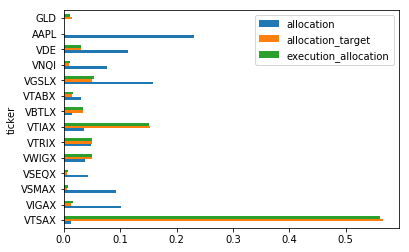

In [30]:
#Lets add a bar chart here to show the new allocation vs. the target allocation and vs. the original portfolio
graph_port = display_port[['ticker','allocation','allocation_target','execution_allocation']].copy()
graph_port.plot.barh(x='ticker')

## Conclusion
Through this portfolio rebalancing demonstration using Pandas you can see we have achieved a rebalanced portfolio very closely approximating our desired target allocation. We can see how GLD was added as a new security, and AAPL was removed from the portfolio. The remaining securities were iteratively bought or sold as required by our target allocation. We accounted for whole-share rounding because most of our assets in this sample are index funds. This simple rebalancer can be adapted to your needs and I urge you grab the code and see if you can improve upon it. I welcome your thoughts or feedback in the comments.